In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']="1"

from fastprogress import master_bar, progress_bar
from fastai.vision import *
from fastai.metrics import accuracy
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.nn as nn
#import pretrainedmodels
import math
import sys
import pickle



In [2]:
#Lets create validations set
df = pd.read_csv('train_sfm120k_1000_classes.csv')

df.Id=df.Id.apply(str)
df.head()


,Image,cluster,Id
0,20/65/c2/4b0ba5a53059bd8a9e5d2a1e49c26520,1,758
1,3a/9a/77/95fed789d3b359425046746061779a3a,10,607
2,4b/ae/48/c6ad055db69cc02b0520b45aa948ae4b,10,607
3,e5/af/6f/0877301841630fd0f3eb0a35c86fafe5,11,370
4,51/90/fb/0e6a84fd2cbc593f0a796901c9fb9051,12,213


In [3]:
im_count = df[df.Id != "-1"].Id.value_counts()
im_count.name = 'sighting_count'
df = df.join(im_count, on='Id')
df.head()
path_prefix = 'data/train/retrieval-SfM-120k/ims'
if True:
    val_fns = set(df.sample(frac=1)[(df.Id != "-1") & (df.sighting_count > 2)].groupby('Id').first().Image)
    val_fns = list(val_fns)
    val_fns2= []
    for k in val_fns:
        val_fns2.append(path_prefix+'/'+k)
    pd.to_pickle(val_fns2, 'data/val_fns_from_train_1000.pkl')

val_fns = pd.read_pickle('data/val_fns_from_train_1000.pkl')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


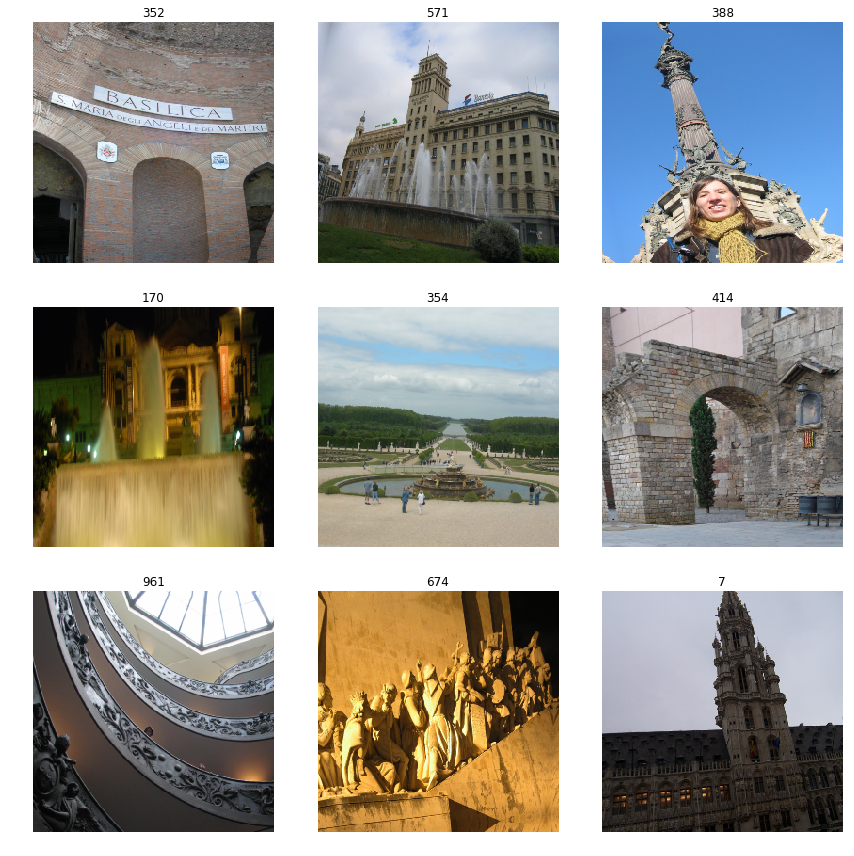

In [4]:
SZ = 256
BS = 48
NUM_WORKERS = 10
SEED=0


DATA_DIR='data/'

name = f'DenseNet121-GeMConst-{SZ}-Ring-CELU'
fn2label = {path_prefix+'/'+row[1].Image: row[1].Id for row in df.iterrows()}
data = (
    ImageList
        .from_df(df[df.Id != "-1"], path=path_prefix, cols=['Image'])
        .split_by_valid_func(lambda path: path in val_fns)
        .label_from_func(lambda path: fn2label[path])
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='')
        .normalize(imagenet_stats)
)
data.show_batch(rows=3)

In [5]:
NUM_CLASSES= len(data.classes)
print (NUM_CLASSES)

780


In [ ]:
from arch import GeM, L2Norm

# Based on my solution to whale-identification-competition
# https://medium.com/@ducha.aiki/thanks-radek-7th-place-solution-to-hwi-2019-competition-738624e4c885
class RingHead(nn.Module):
    def __init__(self, num_classes, feat_dim, in_feat = 1024, r_init =1.5):
        super(RingHead,self).__init__()
        self.eps = 1e-10
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.feature_extractor = nn.Sequential(
                        nn.ReLU(),
                        GeM(3.74), Flatten(),
                        nn.BatchNorm1d(in_feat, eps=1e-05, momentum=0.1,
                                                       affine=True, track_running_stats=True),
                        nn.Dropout(p=0.3),
                        nn.Linear(in_features=in_feat, out_features=feat_dim, bias=True),
                        nn.CELU(inplace=True),
                        nn.BatchNorm1d(feat_dim,eps=1e-05, momentum=0.1,
                                                       affine=True, track_running_stats=True))
        
        self.ring =  nn.Parameter(torch.ones(1).cuda()*r_init)
        self.clf = nn.Sequential(nn.Dropout(p=0.5),
                        nn.Linear(in_features=feat_dim, out_features=num_classes, bias=False))
    def forward(self, x):
        feats = self.feature_extractor(x)
        preds = self.clf(feats)
        return preds,feats

class RingGeMNet(nn.Module):
    def __init__(self, new_model, n_classes, in_feats=1024, out_feats=1024):
        super().__init__()
        self.cnn =  new_model.features
        self.head = RingHead(NUM_CLASSES, out_feats, in_feats)
    def forward(self, x):
        x = self.cnn(x)
        preds,feats = self.head(x)
        return preds,feats
@dataclass
class RingLoss(Callback):
    learn:Learner
    alpha:float=0.01
    def on_loss_begin(self, last_output:Tuple[tensor,tensor], **kwargs):
        "Save the extra outputs for later and only returns the true output."
        self.feature_out = last_output[1]
        return {'last_output':last_output[0]}

    def on_backward_begin(self,
                          last_loss:Rank0Tensor,
                          **kwargs):
        
        x = self.feature_out
        R = self.learn.model.head.ring
        loss = None
        cc=0
        x_norm = x.pow(2).sum(dim=1).pow(0.5)
        diff = torch.mean(torch.abs(x_norm - R.expand_as(x_norm))**2)
        if loss is None:
            loss = diff.mean()
        else:
            loss = loss + diff.mean()
        if self.alpha != 0.:  last_loss += (self.alpha * loss).sum()
        return {'last_loss':last_loss}

In [ ]:
learn = Learner(data, RingGeMNet(models.densenet121(pretrained=True), NUM_CLASSES),
                   metrics=[accuracy],
                   loss_func=nn.CrossEntropyLoss(),
                   callback_fns = [RingLoss])
learn.split([learn.model.cnn, learn.model.head])
learn.freeze()
learn.clip_grad();



In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(20, 1e-2)

In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [ ]:
name = f'DenseNet121-GeM-{SZ}-Ring-CELU'
learn.save(name)

In [ ]:
learn.unfreeze()
max_lr = 1e-3
lrs = [max_lr/5., max_lr]
learn.fit_one_cycle(32, lrs)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()
learn.save(name+"_unfreeze")
#Accuracy gain seems minor, but key factor here is to finetune backbone network 

In [ ]:
from fastai import *
from fastai.vision import *
import torch
from fastprogress import master_bar, progress_bar
import PIL
import matplotlib.pyplot as plt
from third_party.testdataset import configdataset
from third_party.evaluate import compute_map_and_print

import pandas as pd


def open_image_cropped(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image)->Image:
    "Return `Image` object created from image in file `fn`."
    #fn = getattr(fn, 'path', fn)
    x = PIL.Image.open(fn).convert(convert_mode).crop(bbxs[str(fn).replace('./','')])
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(x)

class ImageItemCrop(ImageList):
    def open(self, fn:PathOrStr)->Image:
        return open_image_cropped(fn)

def extract_vectors_batched(data,model,bs):
    model.cuda()
    model.eval()
    num_img = len(data.train_ds)
    vectors = None
    with torch.no_grad():
        idx=0
        for img_label in progress_bar(data.train_dl):
            st=idx*bs
            fin=min((idx+1)*bs, num_img)
            img,label = img_label
            out = model(img).cpu()
            if vectors is None:
                vectors = torch.zeros(num_img, out.size(1))
            vectors[st:fin,:] = out
            idx+=1
    return vectors

def validate_on_dataset(model, dataset_name='oxford5k', DATA_DIR='data/'):
    cfg = configdataset(dataset_name, os.path.join(DATA_DIR, 'test'))
    images = [cfg['im_fname'](cfg,i) for i in range(cfg['n'])]
    qimages = [cfg['qim_fname'](cfg,i) for i in range(cfg['nq'])]
    df = pd.DataFrame(images, columns=['Image'])
    qdf  = pd.DataFrame(qimages, columns=['qimages'])
    global bbxs
    bbxs = {qimages[i]:tuple(cfg['gnd'][i]['bbx']) for i in range(cfg['nq'])}
    BS=1
    NUM_WORKERS=8
    tfms = get_transforms(do_flip=False)
    tfms = (tfms[1],tfms[1]) #no transforms
    query_data = (ImageItemCrop.from_df(qdf,'', cols=['qimages'])
        .split_none()
        .label_const()
        .transform(tfms, resize_method=ResizeMethod.NO)
        .databunch(bs=BS, num_workers=NUM_WORKERS)
        .normalize(imagenet_stats)
       )
    query_data.train_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(query_data.train_ds)
    query_data.train_dl.dl.batch_sampler.drop_last = False
    print ('Extracting query features...')
    query_vectors = extract_vectors_batched(query_data,model, 1)
    data = (ImageList.from_df(df,'', cols=['Image'])
            .split_none()
            .label_const()
            .transform(tfms, resize_method=ResizeMethod.NO)
            .databunch(bs=BS, num_workers=NUM_WORKERS)
            .normalize(imagenet_stats)
           )
    data.train_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.train_ds)
    data.train_dl.dl.batch_sampler.drop_last = False
    print ('Extracting index features...')
    db_vectors = extract_vectors_batched(data,model,1)
    print('>> {}: Evaluating...'.format(dataset_name))
    # convert to numpy
    vecs = db_vectors.numpy()
    qvecs = query_vectors.numpy()
    # search, rank, and print
    scores = np.dot(vecs, qvecs.T)
    ranks = np.argsort(-scores, axis=0)
    compute_map_and_print(dataset_name, ranks, cfg['gnd'])
    return vecs, qvecs #If you want to check some kind of query expansion

In [ ]:
#Neccessary functions from validation notebook are already in utils.py. So lets just import them
#from utils import validate_on_dataset

#Lets create inference network without clf output and with normalization:
class RingGeMNetInfer(nn.Module):
    def __init__(self, new_model, n_classes, in_feats=1024, out_feats=1024):
        super().__init__()
        self.cnn =  new_model.features
        self.head = RingHead(NUM_CLASSES, out_feats, in_feats)
    def forward(self, x):
        x = self.cnn(x)
        preds,feats = self.head(x)
        return L2Norm()(feats)

InferenceNet =  RingGeMNetInfer(models.densenet121(pretrained=True),
                               NUM_CLASSES)
InferenceNet.load_state_dict(learn.model.state_dict())


val_index_feats, val_query_feats = validate_on_dataset(InferenceNet,'oxford5k')

In [ ]:
#What about original barebone network?
class GeMNet(nn.Module):
    def __init__(self, new_model):
        super().__init__()
        self.cnn =  new_model.features
        self.head = nn.Sequential(nn.ReLU(),
                                  GeM(3.0),
                                  Flatten(),
                                  L2Norm())
    def forward(self, x):
        x = self.cnn(x)
        out = self.head(x)
        return out

InferenceNet =  GeMNet(models.densenet121(pretrained=True))
val_index_feats, val_query_feats = validate_on_dataset( InferenceNet,'oxford5k')


In [8]:
print ('now finetuned network')
InferenceNet.cnn.load_state_dict(learn.model.cnn.state_dict())
val_index_feats, val_query_feats = validate_on_dataset(InferenceNet, 'oxford5k')

#Nice! We have improved from 41 mAP on Oxford5k to 50 in just 45 minutes.
# It also seems that learned "head" is too specific to our training dataset, so better to discard it

now finetuned network


NameError: name 'InferenceNet' is not defined

In [33]:
# Now let`s check and idea from https://arxiv.org/pdf/1902.05509.pdf
# train GeM with p=3 with small images (256px), 
# and test on big (1024px), but with increased p=5

class GeMNet(nn.Module):
    def __init__(self, new_model):
        super().__init__()
        self.cnn =  new_model.features
        self.head = nn.Sequential(nn.ReLU(),
                                  GeM(5.0),
                                  Flatten(),
                                  L2Norm())
    def forward(self, x):
        x = self.cnn(x)
        out = self.head(x)
        return out
    
InferenceNet =  GeMNet(models.densenet121(pretrained=True))
InferenceNet.cnn.load_state_dict(learn.model.cnn.state_dict())
validate_on_dataset( InferenceNet, 'oxford5k')

#Seems to work! 

/home.dokt/mishkdmy/anaconda3/envs/fastai1/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Extracting query features...


Extracting index features...


>> oxford5k: Evaluating...
>> oxford5k: mAP 55.73


(array([[0.009218, 0.007043, 0.00896 , 0.008188, ..., 0.0232  , 0.070439, 0.015883, 0.036105],
        [0.007189, 0.007374, 0.009879, 0.007666, ..., 0.048429, 0.043073, 0.021681, 0.056904],
        [0.006041, 0.007137, 0.009219, 0.008475, ..., 0.022902, 0.061748, 0.067738, 0.049438],
        [0.008751, 0.009382, 0.008864, 0.008714, ..., 0.043793, 0.044174, 0.034268, 0.031822],
        ...,
        [0.007183, 0.006371, 0.008266, 0.006075, ..., 0.018051, 0.049209, 0.051562, 0.142529],
        [0.009814, 0.00554 , 0.013052, 0.004439, ..., 0.015529, 0.047355, 0.048079, 0.024149],
        [0.007248, 0.006807, 0.01133 , 0.005945, ..., 0.021319, 0.057661, 0.05075 , 0.078325],
        [0.007446, 0.007827, 0.009641, 0.008125, ..., 0.060203, 0.04535 , 0.02601 , 0.05862 ]], dtype=float32),
 array([[0.008481, 0.00743 , 0.009806, 0.006564, ..., 0.021542, 0.042994, 0.025593, 0.040435],
        [0.008065, 0.007517, 0.008956, 0.003757, ..., 0.034834, 0.043735, 0.047582, 0.080024],
        [0.007505, 0